In [1]:
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
# Load RGB image
def load_image(path):
    return cv2.imread(path)

def load_mask(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

def apply_mask(image, mask):
    return cv2.bitwise_and(image, image, mask=mask)

def resize_image(image, size=(256, 256)):
    return cv2.resize(image, size)

def get_mask_area(mask):
    return np.sum(mask > 0)

def save_csv(df, filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    df.to_csv(filename, index=False)

In [ ]:
def ExtractSegmentOnly(image, mask, keep_transparency=True):
    """
    Extract only the segmented part from the image using the mask.

    Parameters:
        image (numpy array): The input image (BGR).
        mask (numpy array): The binary mask (0, 255).
        keep_transparency (bool): If True, output will have transparency where not masked.
                                  If False, output will be the cropped BGR image.

    Returns:
        numpy array: Cropped segmented image (BGRA if transparency, else BGR).
                     Returns None if no segment found.
    """
    # Ensure mask is binary
    mask_bin = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)[1]

    # Find non-zero mask area
    coords = np.column_stack(np.where(mask_bin > 0))
    if coords.shape[0] == 0:
        return None  # No segmentation found

    # Get bounding box
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)

    # Apply mask on the original image
    masked_img = cv2.bitwise_and(image, image, mask=mask_bin)

    # Crop to the segment area
    cropped = masked_img[y_min:y_max, x_min:x_max]

    if keep_transparency:
        # Convert to BGRA
        cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2BGRA)
        # Crop mask as alpha channel
        alpha_mask = mask_bin[y_min:y_max, x_min:x_max]
        cropped[:, :, 3] = alpha_mask

    return cropped

In [ ]:
def prepare_data(image_dir, mask_dir, output_size=(256, 256)):
    images, masks = [], []
    image_files = sorted(os.listdir(image_dir))

    for img_name in image_files:
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name)

        image = load_image(img_path)
        mask = load_mask(mask_path)

        image = resize_image(image, output_size)
        mask = resize_image(mask, output_size)

        images.append(image)
        masks.append(mask)

    return images, masks

In [ ]:
# Load and split dataset
images, masks = prepare_data('/content/drive/MyDrive/ConjunctivaDataset/Images', '/content/drive/MyDrive/ConjunctivaDataset/Masks Annotator 1')
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

Training set size: 437
Validation set size: 110


In [ ]:
def visualize_samples(image_dir, mask_dir, num_samples=5):
    image_files = sorted(os.listdir(image_dir))[:num_samples]

    plt.figure(figsize=(12, num_samples * 4))

    for idx, img_name in enumerate(image_files):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name)

        image = load_image(img_path)
        mask = load_mask(mask_path)
        masked_img = apply_mask(image, mask)

        # Original Image
        plt.subplot(num_samples, 3, idx * 3 + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Original")
        plt.axis('off')

        # Mask
        plt.subplot(num_samples, 3, idx * 3 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Mask")
        plt.axis('off')

        # Masked Image
        plt.subplot(num_samples, 3, idx * 3 + 3)
        plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
        plt.title("Masked Image")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

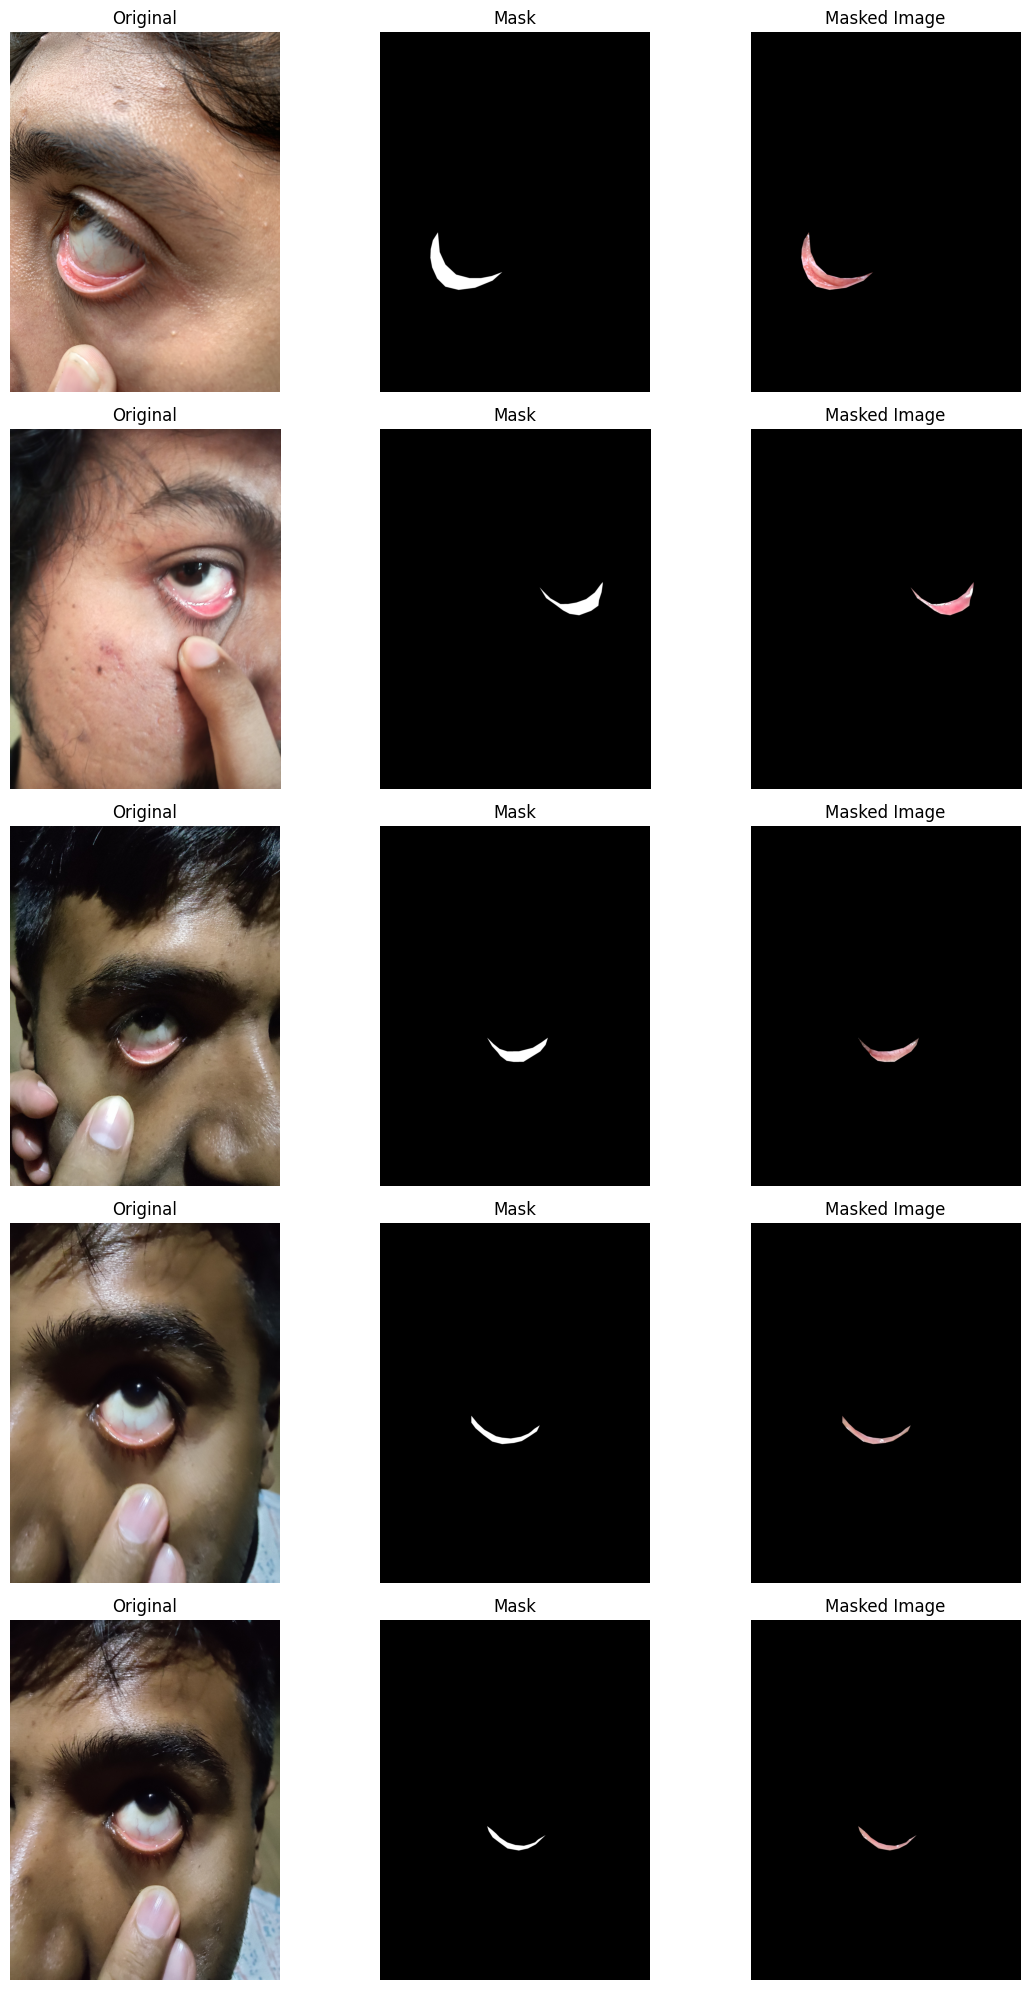

In [ ]:
visualize_samples('/content/drive/MyDrive/ConjunctivaDataset/Images', '/content/drive/MyDrive/ConjunctivaDataset/Masks Annotator 1', num_samples=5)

In [ ]:
def visualize_segmented_only(image_dir, mask_dir, num_samples=5):
    image_files = sorted(os.listdir(image_dir))[:num_samples]

    plt.figure(figsize=(5, num_samples * 4))

    for idx, img_name in enumerate(image_files):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name)

        image = load_image(img_path)
        mask = load_mask(mask_path)
        segmented_only = ExtractSegmentOnly(image, mask)

        plt.subplot(num_samples, 1, idx + 1)
        if segmented_only is not None:
            if segmented_only.shape[2] == 4:
                plt.imshow(cv2.cvtColor(segmented_only, cv2.COLOR_BGRA2RGBA))
            else:
                plt.imshow(cv2.cvtColor(segmented_only, cv2.COLOR_BGR2RGB))
            plt.title("Segmented Only")
        else:
            plt.text(0.5, 0.5, 'No Segment', ha='center', va='center')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# U-Net
def build_unet(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder with skip connections
    c1 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.BatchNormalization()(c1)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

    c2 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.BatchNormalization()(c2)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

    # Bottleneck
    c3 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.BatchNormalization()(c3)

    # Decoder with skip connections
    u1 = tf.keras.layers.UpSampling2D((2,2))(c3)
    u1 = tf.keras.layers.concatenate([u1, c2])
    c4 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(u1)

    u2 = tf.keras.layers.UpSampling2D((2,2))(c4)
    u2 = tf.keras.layers.concatenate([u2, c1])
    c5 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(u2)

    outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c5)

    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
input_shape = (256, 256, 3)
model = build_unet(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ModelCheckpoint('models/unet_best_model.h5', save_best_only=True, monitor='val_loss')
]

history = model.fit(
    x=np.array(X_train),
    y=np.expand_dims(np.array(y_train), axis=-1),
    epochs=10,
    batch_size=8,
    validation_data=(
        np.array(X_val),
        np.expand_dims(np.array(y_val), axis=-1)
    ),
    callbacks=callbacks
)

model.save('/content/drive/MyDrive/ConjunctivaDataset/models/unet_model.h5')

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 285ms/step - accuracy: 0.8478 - loss: -306.1068 - val_accuracy: 0.1885 - val_loss: -3470.2825
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.8045 - loss: -15785.6924 - val_accuracy: 0.3930 - val_loss: -18561.2402
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.8526 - loss: -124977.6016 - val_accuracy: 0.7642 - val_loss: -294.3330
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.8481 - loss: -494959.4688 - val_accuracy: 0.5024 - val_loss: -101950.8828
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.8541 - loss: -1217825.2500 - val_accuracy: 0.7166 - val_loss: -49853.8008
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.8555 - loss: -2838070.5000 - val_accuracy: 0.6571 - val_loss: -1038729.1875
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.8465 - loss: -5349707.0000 - val_accuracy: 0.9363 - val_loss: -501850.2812
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━

In [ ]:
def plot_training_history(history):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Model Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    if 'accuracy' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
        plt.title('Model Accuracy over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    final_train = train_loss[-1]
    final_val = val_loss[-1]

    print("\n--- Overfitting Check ---")
    if final_val > final_train * 1.3:
        print("Possible Overfitting: Validation loss is significantly higher than training loss.")
    elif final_train > final_val * 1.3:
        print("Possible Underfitting or Over-regularization: Training loss is higher than validation loss.")
    else:
        print("No obvious signs of overfitting or underfitting.")

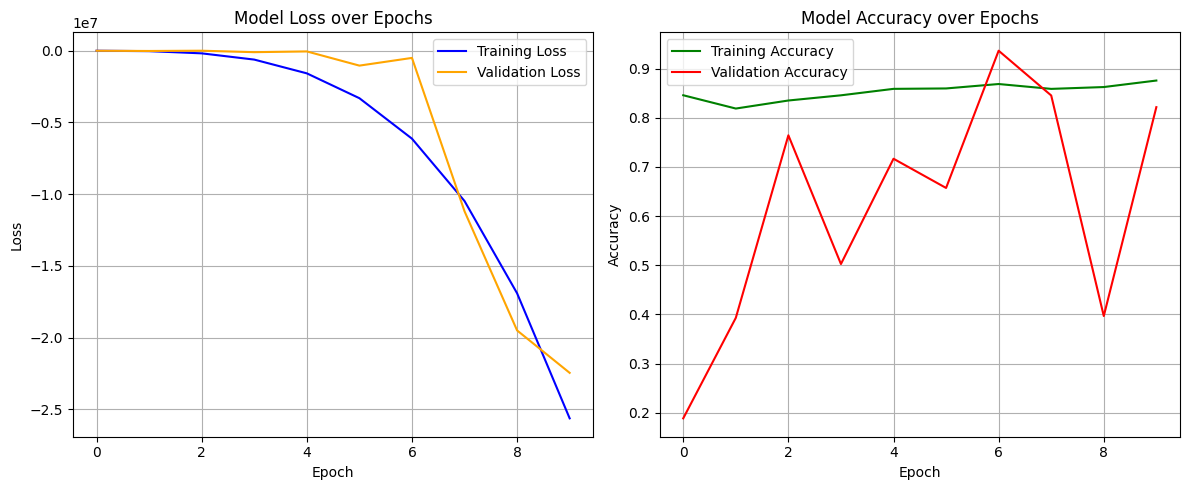


--- Overfitting Check ---
Possible Overfitting: Validation loss is significantly higher than training loss.


In [ ]:
plot_training_history(history)

# **Study and Visualize Segmented Masked Images**

In [ ]:
def segment_and_save(image_dir, mask_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    image_files = sorted(os.listdir(image_dir))

    for img_name in image_files:
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name)

        image = load_image(img_path)
        mask = load_mask(mask_path)
        segmented_only = ExtractSegmentOnly(image, mask)

        if segmented_only is not None:
            output_path = os.path.join(output_dir, img_name)
            cv2.imwrite(output_path, segmented_only)

    print(f"Segmentation and saving completed. Saved to: {output_dir}")



In [ ]:
segment_and_save('/content/drive/MyDrive/ConjunctivaDataset/Images', '/content/drive/MyDrive/ConjunctivaDataset/Masks Annotator 1', '/content/drive/MyDrive/ConjunctivaDataset/SegmentedImages')

Segmentation and saving completed. Saved to: /content/drive/MyDrive/ConjunctivaDataset/SegmentedImages


In [ ]:
def visualize_segmented_samples(output_dir, num_samples=5):
    segmented_files = sorted(os.listdir(output_dir))[:num_samples]

    plt.figure(figsize=(num_samples * 5, 5))

    for idx, img_name in enumerate(segmented_files):
        img_path = os.path.join(output_dir, img_name)
        segmented_img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)  # handle both RGB and RGBA

        plt.subplot(1, num_samples, idx + 1)
        if segmented_img.shape[2] == 4:
            plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGRA2RGBA))
        else:
            plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))

        plt.title(f"Segmented {img_name}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

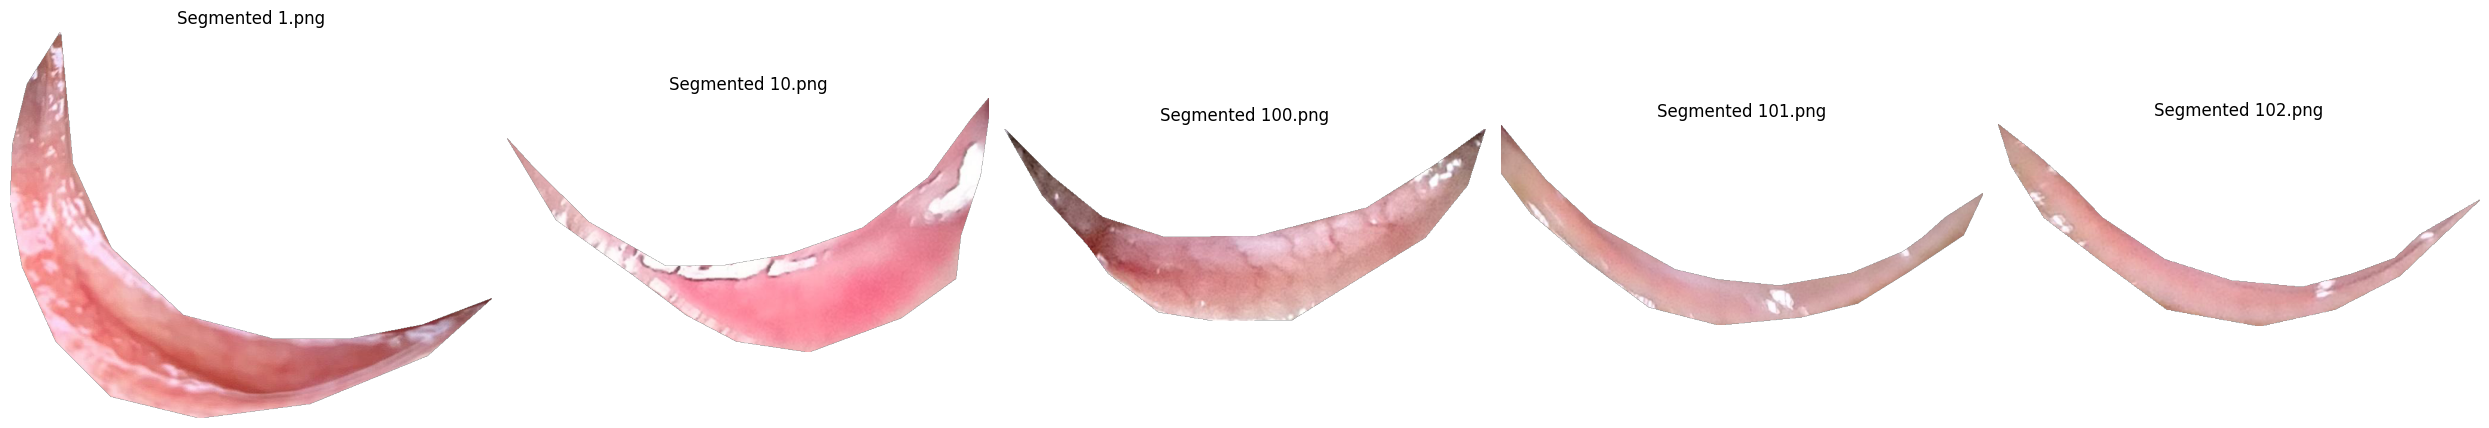

In [ ]:
visualize_segmented_samples('/content/drive/MyDrive/ConjunctivaDataset/SegmentedImages', num_samples=5)

In [ ]:
!pip install mahotas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 2.5 MB/s eta 0:00:00


In [ ]:
import mahotas

def extract_features_with_mahotas(image_dir, output_excel='/content/drive/MyDrive/ConjunctivaDataset/outputs/Features_CSV/Features_mahotas.xlsx'):
    os.makedirs('/content/drive/MyDrive/ConjunctivaDataset/outputs/Features_CSV/outputs/Features_CSV', exist_ok=True)
    feature_list = []
    image_files = sorted(os.listdir(image_dir))

    for img_name in image_files:
        img_path = os.path.join(image_dir, img_name)
        img = cv2.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Compute Haralick texture features
        haralick = mahotas.features.haralick(gray).mean(axis=0)

        features = {
            'Image_name': img_name,
            **{f'Feature-{i}': val for i, val in enumerate(haralick)}
        }

        feature_list.append(features)

    df = pd.DataFrame(feature_list)
    df.to_excel(output_excel, index=False)
    print(f"Feature file saved to: {output_excel}")


In [ ]:
extract_features_with_mahotas('/content/drive/MyDrive/ConjunctivaDataset/SegmentedImages')

Feature file saved to: /content/drive/MyDrive/ConjunctivaDataset/outputs/Features_CSV/Features_mahotas.xlsx


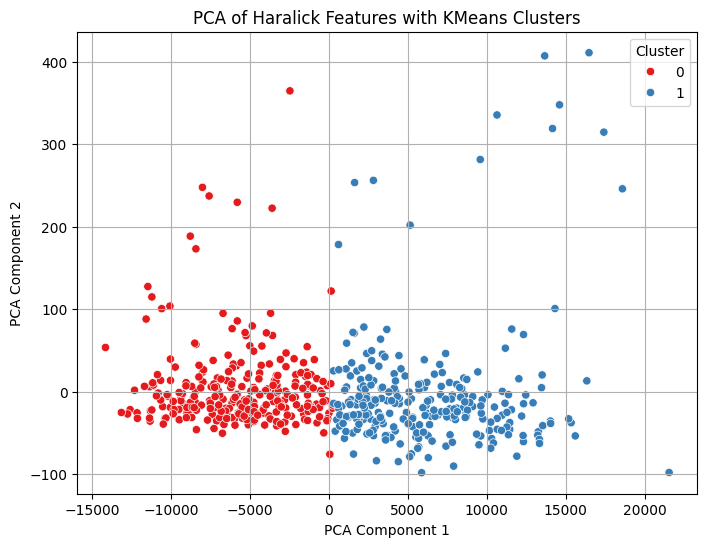

In [ ]:
def run_analysis(feature_excel):
    df = pd.read_excel(feature_excel)
    X = df.drop('Image_name', axis=1)

    # PCA
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(X)

    # KMeans
    kmeans = KMeans(n_clusters=2, random_state=42)
    clusters = kmeans.fit_predict(X)

    # Plotting
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=pca_features[:,0], y=pca_features[:,1], hue=clusters, palette='Set1')
    plt.title('PCA of Haralick Features with KMeans Clusters')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

run_analysis('/content/drive/MyDrive/ConjunctivaDataset/outputs/Features_CSV/Features_mahotas.xlsx')

# Classification

In [ ]:

df = pd.read_excel("/content/drive/MyDrive/ConjunctivaDataset/outputs/Features_CSV/Features_mahotas.xlsx")

# Assign labels to all 547 rows (adjust this logic based on your actual label info)
df['Label'] = ['Normal'] * 273 + ['Affected'] * 274

# Separate features and target
X = df.drop(columns=['Image_name', 'Label'])  # Be sure column names match exactly
y = df['Label']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=42)
svm = SVC()

knn.fit(X_train, y_train)
rf.fit(X_train, y_train)
svm.fit(X_train, y_train)

# Make predictions
knn_pred = knn.predict(X_test)
rf_pred = rf.predict(X_test)
svm_pred = svm.predict(X_test)

# Evaluate each model
models = {
    'KNN': knn_pred,
    'Random Forest': rf_pred,
    'SVM': svm_pred
}

In [ ]:
for name, preds in models.items():
    print(f"\n--- {name} ---")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, preds))
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Classification Report:")
    print(classification_report(y_test, preds))


--- KNN ---
Confusion Matrix:
[[31 16]
 [34 29]]
Accuracy: 0.5454545454545454
Classification Report:
              precision    recall  f1-score   support

    Affected       0.48      0.66      0.55        47
      Normal       0.64      0.46      0.54        63

    accuracy                           0.55       110
   macro avg       0.56      0.56      0.55       110
weighted avg       0.57      0.55      0.54       110


--- Random Forest ---
Confusion Matrix:
[[40  7]
 [22 41]]
Accuracy: 0.7363636363636363
Classification Report:
              precision    recall  f1-score   support

    Affected       0.65      0.85      0.73        47
      Normal       0.85      0.65      0.74        63

    accuracy                           0.74       110
   macro avg       0.75      0.75      0.74       110
weighted avg       0.76      0.74      0.74       110


--- SVM ---
Confusion Matrix:
[[31 16]
 [24 39]]
Accuracy: 0.6363636363636364
Classification Report:
              precision    rec

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

Saved clustering plot as clustering_results/KMeans_Clustering_PCA.png


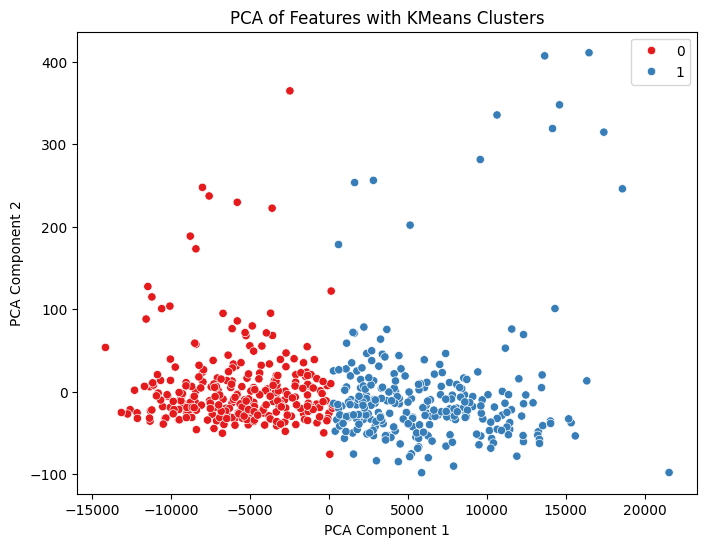

In [ ]:
def load_features(feature_file):
    df = pd.read_excel(feature_file)
    X = df.drop(['Image_name'], axis=1)
    return X

def run_kmeans_clustering(feature_file, save_dir='clustering_results'):
    os.makedirs(save_dir, exist_ok=True)
    X = load_features(feature_file)

    # KMeans Clustering
    kmeans = KMeans(n_clusters=2, random_state=42)
    clusters = kmeans.fit_predict(X)

    # PCA for visualization
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(X)

    # Plot PCA with clusters
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=pca_features[:,0], y=pca_features[:,1], hue=clusters, palette='Set1')
    plt.title('PCA of Features with KMeans Clusters')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')

    save_path = os.path.join(save_dir, 'KMeans_Clustering_PCA.png')
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    print(f"Saved clustering plot as {save_path}")
    plt.show()

run_kmeans_clustering('')
